# Проект по исследованию закономерностей успешности игр

В данном проекте мы будем работать на выделение главных тенденций и закономерностей, которые определяют для успешность игр. 
Данные будут до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. 
Из информации для ознакомления - будет представлен датасет с данными, в которых будут столбцы. Список столбцов такой:

Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100)

User_Score — оценка пользователей (максимум 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Теперь приступим непосредственно к проекту.

## Изучение и просмотр датасета

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import warnings
import seaborn as sns

data = pd.read_csv('games.csv')

В начале, и прежде всего стои начать с прочитки данных и изучить общим взглядом весь датасет. Так же добавляем библиотеки которые позже пригодятся при работа над проектом.

In [16]:
print(display(data.head()))
print()
print('Размер таблицы:', data.shape)
print()
data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


None

Размер таблицы: (16715, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Беглым взглядом сразу видно несколько различных ошибок и недочетом в датасете, как чутка не те типы данных, пропуски где то понятные, где то нет. Все это проверим.

## Предобработка и подготовка данных

### Предобработка

In [17]:
data.rename(str.lower, axis='columns', inplace=True)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Начнем с подготовки "почвы" для дальнеших исследований. Первым делом приведем столбцы в нижний регистр, так будет как минимум лучше смотреться.

In [18]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [19]:
data.dropna(subset=['name', 'genre'], inplace=True)
data['year_of_release'] = data['year_of_release'].fillna(0)
data['rating'] = data['rating'].fillna('NR')
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating                0
dtype: int64

Теперь обработаем пропуски при необходимости такой в столбцах, проверим где их и сколько. Как видно, пропуски в основном в 3 последних столбцах, но сначала разберемся с другими. В столбцах name и genre по 2 пропуска на 16000 строк, и без зазрения совести я их уберу. 

И в столбце с годом выпуска, каким то определенным образом заменить дату нельзя, нехватка информации, просто заменим на 0 значения пропущенные, для обработки типа данных потом(ведь 269 строк тоже роли практически не играют в статистике).

И так же, для учета рейтинга, чтобы даже безрейтинговые игры могли попасть в какие либо анализы, преобразую пропуски в столбце рейтинга на NR(No rating).

In [20]:
data['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.2       2
0.7       2
9.6       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Теперь с "непростыми" столбцами, где пропуски нельзя обусловить ничем по идее. Глянем на какие то может быть аномалии.
Из интересного - это значения tbd в столбце user_score, аж 2424 строки. 
Если я правильно понимаю, то это аббревиатура на to be determined, то есть еще не определено. Это преобразуем позже.

А в остальных столбцах, я боюсь, обоснованно преобразовывать или выбрасывать пропуски нельзя, нехватает данных для этого. Эти пропуски вероятно потерялись при образовании данных, или по непопулярности какой либо игры. Наверняка знать трудно.

In [21]:
data['year_of_release'] = data['year_of_release'].astype('int')
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data.duplicated().sum()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NR
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NR


Далее преобразуем данные в нужный тип, там где это было бы к месту и необходимо. И проверим наличие дубликатов в строках(их не обнаружилось)

### Подготовка

In [22]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NR,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NR,31.38


И напоследок в этом разделе, посчитаем общие продаэи по играм во всем мире и запишем в столбец total_sales.

## Исследовательский анализ 

### Важны ли годы?

In [23]:
data_years = data.query('year_of_release != 0')
data_years['year_of_release'].min()

1980

И так, начнем исследовать. Для начала стоит посмотреть количество игры выпускаемых в разные годы. Построим график, показывающий это, но т.к. некоторые строки были с пропусками, и теперь они 0, то посмотрим сначала из среза где годы не равны 0, какая самая ранняя игра и построим график.

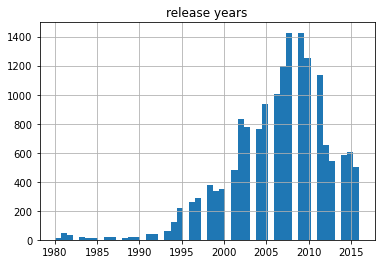

In [24]:
plt.title('release years')
data['year_of_release'].hist(bins=50, range=(1980,2016), grid=True)
plt.show()

In [11]:
def periods(year):
    if year < 1995:
        return 'pre_boom_era'
    if 1995 <= year < 2008:
        return 'boom_era'
    if 2008 <= year < 2013:
        return 'post_boom_era'
    return 'modern_era'
data['year_period'] = data['year_of_release'].apply(periods)

Как видно на графике, огромный скачок в продаже игры произошел в период с 1995 по примерно 2008. До 95-го года игры даже 100 млн копий не достигали, популярность была крайне низкой. Предположу, что рост популярности стал как раз в годы массовой доступности компьютеров. И различные большие и маленькие студии начали делать игры в больших количествах. И естественно, кто то их них, да выстрелил. А дальше, уже за порогом 2008 года ажиотаж на игры начал спадать, и так и продолжает пока. 
Было бы разумно разделить все годы на периоды до и после "бума".
Сделаем столбец такой. Вероятно это будет важно.

А непосредственно этот спад после бума я думаю можно объяснить тем, что  примерно в это время в индустрию вошли мобильные телефоны, который на данный момент наверняка занимают огромную часть всей прибыли продаж.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Как думаешь, с чем связан спад в последние годы?

</div>

### Как менялись платформы?

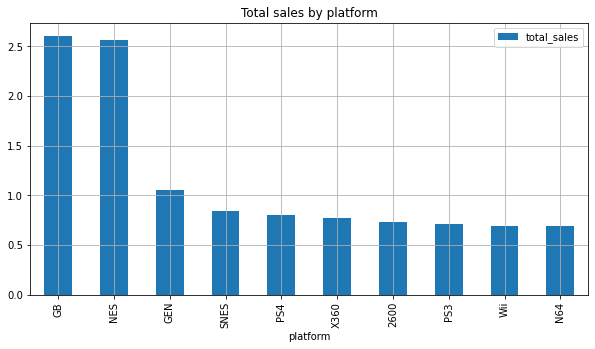

In [12]:
data.pivot_table(index='platform', values='total_sales').sort_values(by='total_sales', ascending=False).head(10).plot(kind='bar',grid=True, figsize=(10, 5), title='Total sales by platform')
plt.show()

Посмотрим суммарные продажи по платформам перебивших миллиард, и выходит так, что их всего 3, и каждая из них, мягко сказать "доисторическая", так как, предположу, что в то время, просто не было разнообразия в выборе. И дальше подобравшиеся к миллиардникам уже идут примерно современные платформы.

### Какие платформы лидируют?

In [13]:
data_modern = data.query('year_period == "modern_era"')
data_modern.pivot_table(index='platform', values='total_sales').sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS4,0.801378
X360,0.735484
XOne,0.645020
Wii,0.593913
WiiU,0.562000
PS3,0.525884
3DS,0.472772
PC,0.208624
DS,0.192500


In [14]:
data_modern.pivot_table(index='platform', values='year_of_release').sort_values(by='year_of_release', ascending=False).astype('int')

,year_of_release
platform,
PS4,2015
XOne,2014
PC,2014
PSV,2014
3DS,2014
WiiU,2014
PS3,2014
X360,2013
Wii,2013


И так, вот данные по продажам за последние 4 года, и ожидаемо, в лидерах находятся PS4 и Xбоксы разных покалений. Так же ожидаемо, что старые платформы которые выходили в начале этого периода, уже начианют сбавлять обороты и теряют продажи, по сравнению с платформами нового поколения. Яркие примеры - PS3 и X360. Самым потенциальным вариантом среди новых платформ естественно 2 платформы нового поколения PS4 b XOne, даже по продажам они уже в топах. Относительно интересно еще смотриться WiiU, выпущенная тоже относительно недавно и держащаяся достаточно высоко в продажах.

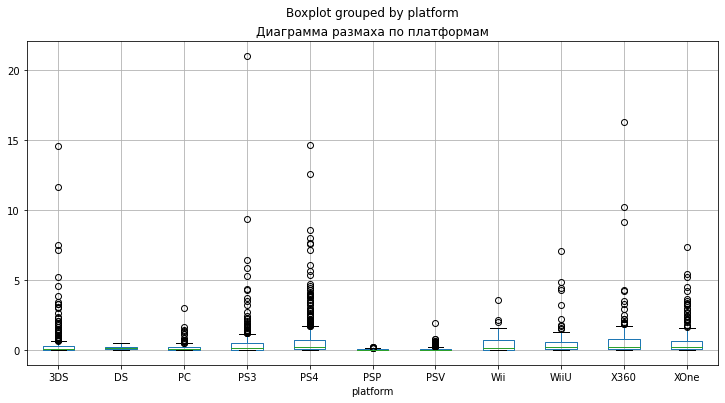

In [29]:
import warnings
warnings.filterwarnings("ignore")
data_modern.boxplot(by='platform', column='total_sales', figsize=(12,6))
plt.title('Диаграмма размаха по платформам')
plt.show()

И так уже окончательно тут можно разглядеть, что платформы, которые были описаны ранее, являются самыми прибыльными. Это можно сказать по разбросу высоких значний и медиане. видно, что у платформ нового поколения она выше чем у своих других конкурентов. И как и было сказано так же про WiiU, он тоже достаточно неплохо держится.

А само распределение платформ по таким разным разбросам можно объяснить вероятно, кроме популярности мастадонтов из Сони и Майкрософт, еще и мощностью платформ, их портативностью, как у PSP. Почему то последнее как раз не очень популярно на рынке, предположительно как раз из за молой мощности и большой цены на приставку. ЧТо коненчно не скажешь про 3DS, которая получила ошромную популярность для портативной приставки за счет некоторых культовых игр там.

### Влияние на одну платформу

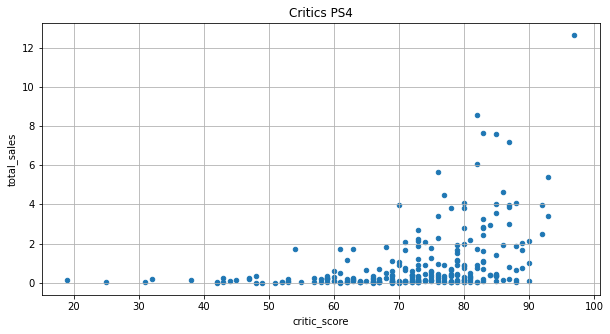

0.40656790206178095


In [48]:
data_ps4 = data.query('platform == "PS4"')
data_ps4.plot(kind='scatter', x='critic_score', y='total_sales', grid=True, figsize=(10,5), title='Critics PS4')
plt.show()
print(data_ps4['critic_score'].corr(data_ps4['total_sales']))

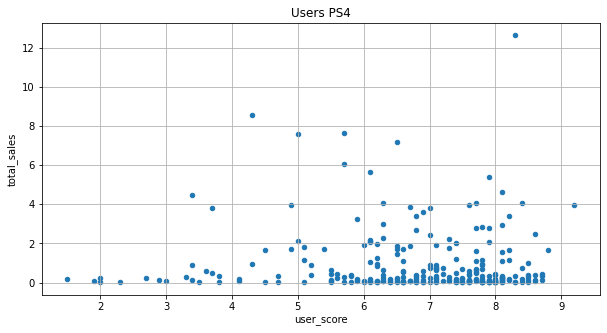

-0.031957110204556424


In [49]:
data_ps4.plot(kind='scatter', x='user_score', y='total_sales', grid=True, figsize=(10,5), title='Users PS4')
plt.show()
print(data_ps4['user_score'].corr(data_ps4['total_sales']))

И так, какие же здесь можно сделать выводы. А очень интересные. 

После того, как мы выбрали для эксперимента самую прибыльную и популярную платформу современности, мы увидели после постройки двух диаграмм рассеивания, что влияние на продажи у критиков и пользователей разное. И после проверки корреляцией вообще показало, что оценки критиков значительно влияют на продажи, в то время как оценки пользователей, практически никак не влияют же на них.

Но стоит проверить и на других популярных платформах, так же ли.

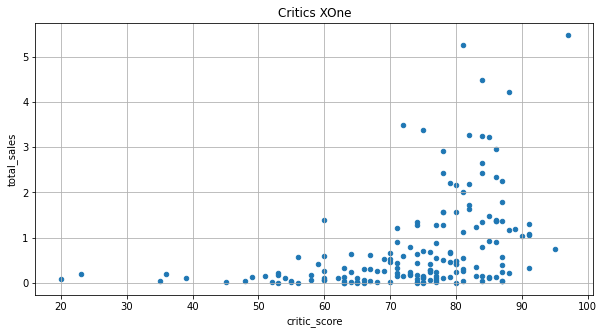

0.4169983280084017


In [50]:
data_x = data.query('platform == "XOne"')
data_x.plot(kind='scatter', x='critic_score', y='total_sales', grid=True, figsize=(10,5), title='Critics XOne')
plt.show()
print(data_x['critic_score'].corr(data_x['total_sales']))

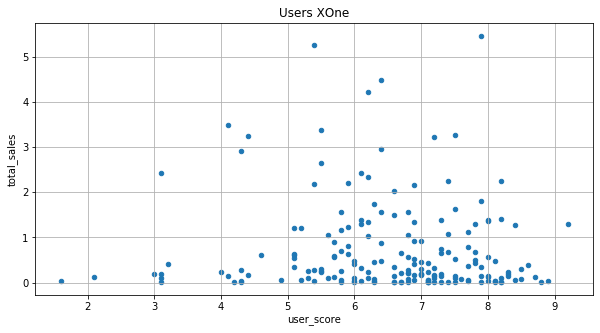

-0.06892505328279414


In [20]:
data_x.plot(kind='scatter', x='user_score', y='total_sales', grid=True, figsize=(10,5), title='Users XOne')
plt.show()
print(data_x['user_score'].corr(data_x['total_sales']))

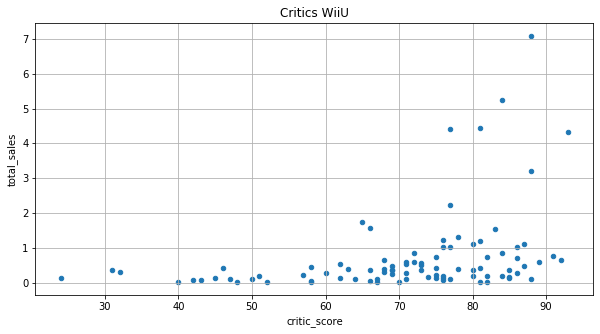

0.34837976012017485


In [21]:
data_w = data.query('platform == "WiiU"')
data_w.plot(kind='scatter', x='critic_score', y='total_sales', grid=True, figsize=(10,5), title='Critics WiiU')
plt.show()
print(data_w['critic_score'].corr(data_w['total_sales']))

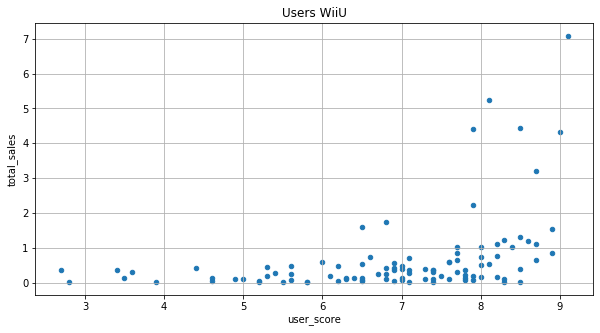

0.4002190202148617


In [22]:
data_w.plot(kind='scatter', x='user_score', y='total_sales', grid=True, figsize=(10,5), title='Users WiiU')
plt.show()
print(data_w['user_score'].corr(data_w['total_sales']))

Теперь возьмем 2 платформы, XOne и WiiU.
И соотнесем выводы для PS4 с ними.
Видно сразу, что со сверхпопулярными платформами правило остается неизменным.
Однако интереное выявленно было в WiiU. Тут, Как ни странно, но влияние пользователей больше сказывалось на продажи конкретно по этой платформе, выявленное корреляцией, значит, правило как с PS4 и другими платформами не всегда правдиво.

### Распределение по жанрам

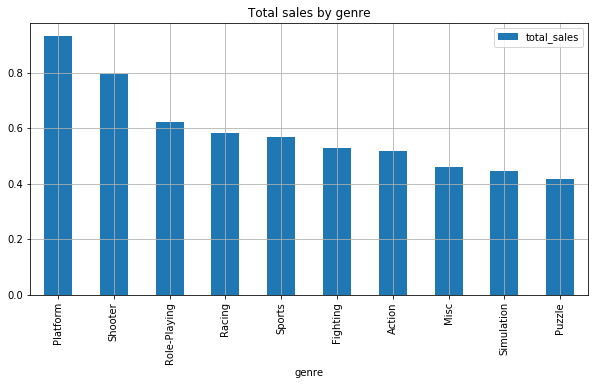

In [23]:
#data['genre'].value_counts()
data.pivot_table(index='genre', values='total_sales').sort_values(by='total_sales', ascending=False).head(10).plot(kind='bar', grid=True, figsize=(10, 5), title='Total sales by genre')
plt.show()

И так, в отоншении жанров тут картина достаточно очевидная. Мы сделали распределение показывающее прибыль по жанрам, и тут как видно, самым прибыльным жанром является платформер. Это наверняка связано с предыдущими распределениями по продажам в платформах. Все и логично, опять же, кроме платформеров раньше мало что было:D 

Дальше идет шутеры и ролевые игры, что тоже логично. Огромный бум популярности как раз ролевыйх был во время общего бума игр, а шутеры всегда считались популярны.

Что же из самых низкоприбыльных играх, то тут пазлы и симуляторы. Предположительно это можносвязать с целесообразностью компьютерных игр как таковых. Ведь большинство людей ищут в них досуг, расслабление от, возмонжно больших интелектуальных нагрузок, и игры направленные на точное потворствование реальности и головоломки не всегда могут дать такой "легкий" досуг.

## Составление портретов пользователей

Приступим к изучению различных регионов по различным показателям. Смотреть будем по разным параметрам - продажи по платформам, продажи по жанрам и как влияет ли рейтинг ESRB в данном регионе на продажи

### Регион NA

In [24]:
data_na_pl = data_modern.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()
data_na_pl

,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


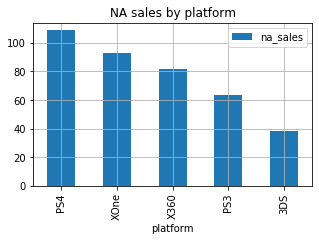

In [25]:
data_na_pl.plot(kind='bar', grid=True, figsize=(5, 3), title='NA sales by platform')
plt.show()

In [26]:
data_na_gnr = data_modern.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()
data_na_gnr

,na_sales
genre,
Action,126.05
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


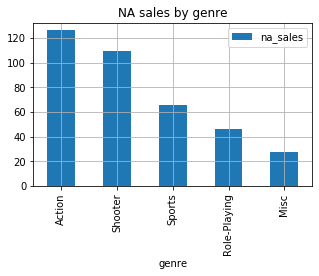

In [27]:
data_na_gnr.plot(kind='bar', grid=True, figsize=(5, 3), title='NA sales by genre')
plt.show()

In [28]:
data_na_rt = data_modern.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()
data_na_rt

,na_sales
rating,
M,165.21
NR,89.42
E,79.05
E10+,54.24
T,49.79


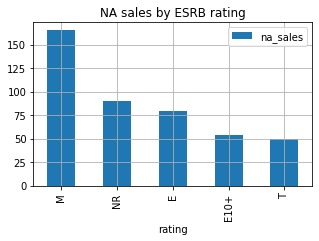

In [29]:
data_na_rt.plot(kind='bar', grid=True, figsize=(5, 3), title='NA sales by ESRB rating')
plt.show()

Начнем с региона Северной Америки. 

Платформы - как видно, самыми прибыльными 5 платформами остаются самые очевидные варианты. На первом месте с отрывом небольшим все же японская PS4 перебила конкурентов из США, располагающихся на 2 и 3 местах. Так же в топах пока что остается PS3( и предположительно еще минимум 2 года будет там) и 3DS, самая популярная портативная консоль, тут ей нет равных.

Жанры - тут же все закономерно, однако за перве место развернулась борьба, между шутерами (как в мировом рейтинге) и экшн играми, и дальше уже интересные жанры, спорт, ММО и разное. Каждая из этих последних 3 была широко распространена как на старых, так и на новых платформах.

Ну и рейтинг ESRB интересно повлиял на продажи в Северной Америке. В данном регионе аудитории важно, чтобы в играх были дозволены вещи, так скажем не для детей(предположу что в плане насилия и крови). Продажи в этом рейтинге с большим отрывом находятся тут. Второй строкой находятся игры не обозначеные рейтингом, а дальше все достаточно логично, игры для всех стоят на третей строчке, и сразу после не очень популярный тип игр для подростков и детей чуть младше.

### Регион EU

In [30]:
data_eu_pl = data_modern.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()
data_eu_pl

,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


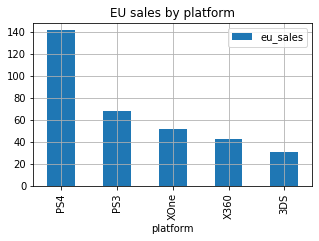

In [31]:
data_eu_pl.plot(kind='bar', grid=True, figsize=(5, 3), title='EU sales by platform')
plt.show()

In [32]:
data_eu_gnr = data_modern.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()
data_eu_gnr

,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


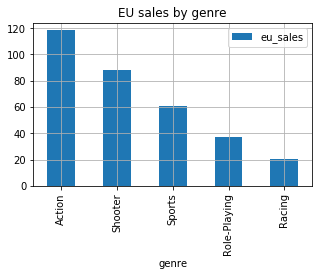

In [33]:
data_eu_gnr.plot(kind='bar', grid=True, figsize=(5, 3), title='EU sales by genre')
plt.show()

In [34]:
data_eu_rt = data_modern.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()
data_eu_rt

,eu_sales
rating,
M,145.32
E,83.36
NR,78.91
E10+,42.69
T,41.95


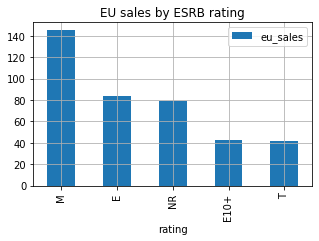

In [35]:
data_eu_rt.plot(kind='bar', grid=True, figsize=(5, 3), title='EU sales by ESRB rating')
plt.show()

Теперь Европейский регион, посмотрим что здесь.

Платформы - среди топа платформ уже картина категорически другая. В лидерах стоят последние 2 PS консоли, перегоняя топ консоли США на порядок. Самым большим сюрпризом здесь несомненно как раз вторая строчка рейтинга топ5 -  старая консоль PS3. Ну и замыкает снова же, самая порпулярная порт.консоль 3DS.

Жанры - Здесь все почти что идентично с Северной Америкой как по продажам, так и по топ5. За иключением что только в Европе, гонки все же немного популярнее своих других конкурентов.

Что же до влияния рейтинга на продажи, тут все так же как и в Америке. Только выделить можно немного большую популярность игры для тинейджеров(вероятно этот уникальный ньюанс заметен в какой то стране Европы) и достаточно большой граф по безрейтинговым играм.

### Регион JP

In [36]:
data_jp_pl = data_modern.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()
data_jp_pl

,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


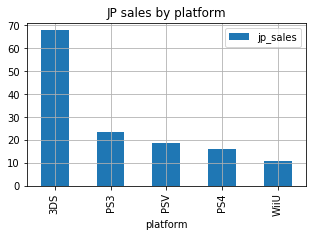

In [37]:
data_jp_pl.plot(kind='bar', grid=True, figsize=(5, 3), title='JP sales by platform')
plt.show()

In [38]:
data_jp_gnr = data_modern.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()
data_jp_gnr

,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.20
Fighting,7.65
Shooter,6.61


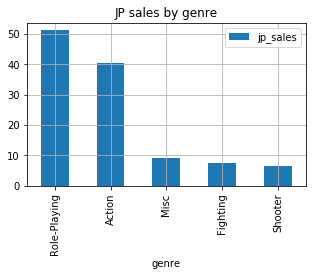

In [39]:
data_jp_gnr.plot(kind='bar', grid=True, figsize=(5, 3), title='JP sales by genre')
plt.show()

In [40]:
data_jp_rt = data_modern.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()
data_jp_rt

,jp_sales
rating,
NR,85.05
T,20.59
E,15.14
M,14.11
E10+,5.89


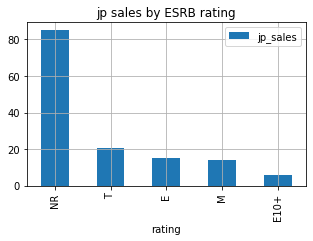

In [41]:
data_jp_rt.plot(kind='bar', grid=True, figsize=(5, 3), title='jp sales by ESRB rating')
plt.show()

Ну и наконец Япония, родина многих культовых платформ и игр, как же тут дела.

Платформы - тут конечно разница огромная, по сравнению с другими регионами. Даже дело не в том, что здесь продажи по ним как таковые меньше, что резонно, ведь Япония просто меньше регион по количеству людей чем его конкуренты. А дело в платформах. Здесь популярностью пользуются как раз таки, портативные платформы. в топ5 3/5 платформ - портативки. Первое месте несомненно родная консоль от нинтендо - 3DS, а вот второе место, опять на удивление старая PS3. И далее уже идут конкуренты(если их можно так назвать) 3DS, это PS Vita и WiiU. Но пусть в мире они не составляют конкуренцию, в Японии же картина очень даже соревновательная. Продажи близкие.

Жанры - И снова не удивительно, но немного другая картина чем в США и Канаде - лидер MMO что достаточно логично объяснено. Огромный процент всех MMO(как старых так и новых) от сюда, из Японии. Так же, экшн игры занимают свою вторую строчку с мальенким отставанием от MMO. Но далее, идет большущий отрыв от других жанров. Продажи у 3-5 места вместе взятые даже не наберут и второго места. Что вероятно дает намек, что совершернно другой контингент здесь, в Японии.

И влияние рейтинга здесь, очень неординарное. Если не считать огромный процент безрейтинговых игры, которые просто вероятно не дошли до главного рейтинга(возможно в Японии есть свой), то можно выделить - Игры для взрослых здесь не играют главенствующую роль. А играет ее - тинейджерские игры. Япония, как другая планета.

## Проверка гипотез

И наконец, практически финишная черта - проверка гипотез, чтобы ответить на важнейшие вопросы и спрогнозировать стратегии на будущий год.

Для чистоты эксперимента(или гипотезы) так же проведем небольшие проверки схожести дисперсий проверяемых значений.

Значение критической значемости 5%
Приступим.

### Гипотеза 1

In [42]:
test1 = data_modern.query('platform == "XOne"')['user_score']
test2 = data_modern.query('platform == "PC"')['user_score']
var1 = np.var(test1, ddof=1)
var2 = np.var(test2, ddof=1)
print(var1, var2)

1.9069968429360695 3.035892752408881


In [43]:
alpha = 0.05
hypothesis1 = st.ttest_ind(test1, test2, equal_var=False, nan_policy='omit')
print('p-значение:', hypothesis1.pvalue)

if hypothesis1.pvalue < alpha:
    print("Выкидываем нулевую гипотезу")
else:
    print("Не получилось выкинуть нулевую гипотезу")

p-значение: 0.1475959401343003
Не получилось выкинуть нулевую гипотезу


Первая гипотеза, она же нулевая гласит - средние пользовательские рейтинги платформ Xbox One и PC одинаковые. От сюда следует, что альтернативой этому будет любое отклонение дисперсий от равенства друг другу. Для проверки данной гипотезы проверим столбцы user_score со срезами по данным нам платформам, чтобы считать критерии оценки от туда.

Как выясняется, то все таки нулевая гипотеза оказалась имеет место быть. Судя по результатам теста, оценки пользователей примерно одинаковы на ПК и Xbox One. Это говорит вероятно о непопулярности консоли в мире.

### Гипотеза 2

In [44]:
test1_1 = data_modern.query('genre == "Action"')['user_score']
test2_1 = data_modern.query('genre == "Sports"')['user_score']
var1_1 = np.var(test1_1, ddof=1)
var2_1 = np.var(test2_1, ddof=1)
print(var1_1, var2_1)

1.7693609042482705 3.180612814465409


In [45]:
alpha = 0.05
hypothesis2 = st.ttest_ind(test1_1, test2_1, equal_var=False, nan_policy='omit')
print('p-значение:', hypothesis2.pvalue)

if hypothesis2.pvalue < alpha:
    print("Выкидываем нулевую гипотезу")
else:
    print("Не получилось выкинуть нулевую гипотезу")

p-значение: 1.446003970070351e-20
Выкидываем нулевую гипотезу


И вторая гипотеза, которая говорит - средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. Тоесть, по правилам тестов, это будет наша альтернативная гипотеза. И к ней соответственно прибавим нулевую - смысл которой что, средние пользрвательские рейтинги в данных жанрах равны. И критерии будут такие же как в первой гипотезе, за исключением других срезова уже по жанрам.

И какой результат. Все таки изначально данная альтернативаная гипотеза оказалась верна, или другими словами, нулевая гипотеза выкидывается. Это значит, что все таки рейтинги которые давали пользователи были практически совершенно разные в этих двух жанрах для проверки.

## Общий вывод

В заключении ко всей работе, можно сказать несколько вещей.
Самой потенциально прибыльной платформой можно со спокойной душой считать флагманы рынка PS4 и Xbox One(а их старые версии уже не стоит), они показывают хорошие цифры по современным меркам продаж, "постбума". Так же, стоит отметить черную лошадку платформ, WiiU, которая так же в последние годы держалась пусть и не в лидерах, но стабильно в вершине топов.

Однако стоит помнить еще 2 вещи - жанры и регионы.
По жанрам картина остается относительно одинакова для современности -шутеры и экшн игры, безошибочный вариант, но не для Японии к примеру.
В расчет необходимо учитывать национальные предпочтения в жанрах. К примеру для Европейской сцены не будет ошибкой вложитсья в спорт игры или гонки, а уже для Японии, опять же, будет хорошим ходом - в MMO и экшн. 

Мир игр очень разнообразен, и для каждой мелочи и выбора, нужно все хорошо обдумать и основательно подойти к вопросу.